# Post-processing of case studies

## Usage notes

All figures will be written to the directory `img` as pdf and png files.

I run this notebook on Ubuntu, using this version of matplotlib:
```
pip freeze | grep matplotlib
matplotlib==2.1.0
```
Some older versions return an error because they do not support some plot configurations.
I set in the virtual machine the RAM to 12GB as 8GB is not sufficient to parse two annual result files.

## Import required libraries

In [1]:
import gc
import os

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

from buildingspy.io.outputfile import Reader
from buildingspy.io.postprocess import Plottera

# Local import.
import cases

## Configure plots

In [2]:
plt.rcParams['axes.facecolor']='whitesmoke'
plt.rcParams['font.size'] = 6
plt.rcParams['text.usetex'] = False
plt.rcParams['legend.facecolor'] = 'white'
plt.rcParams['legend.framealpha'] = 0.75
plt.rcParams['legend.edgecolor'] = 'none'
plt.rcParams['savefig.dpi'] = 300

def save_plot(figure, file_name):
    """ Save the figure to a pdf and png file in the directory `img`
    """
    import os
    import matplotlib.pyplot as plt
    
    out_dir = "img"
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    figure.savefig(os.path.join(out_dir, '{}.pdf'.format(file_name)))
    figure.savefig(os.path.join(out_dir, '{}.png'.format(file_name)))
    plt.clf()
    

def configure_axes(axes):
    """ Configure the axis style
    """
    axes.spines['right'].set_visible(False)
    axes.spines['top'].set_visible(False)
    axes.spines['left'].set_visible(False)
    axes.spines['bottom'].set_visible(False)
    axes.grid(color='lightgrey', linewidth=0.25)
    return

def get_results(case_name):
    """ Get the results for the case with name `case_name`
    """
    # Make sure simulation was successful
    dslog_name = os.path.join("simulations", case_name, "dslog.txt")
    with open(dslog_name) as dslog:
        if not "Integration terminated successfully" in dslog.read():
            raise Exception("Simulation failed. Check {}".format(dslog_name))
    file_name = cases.get_result_file_name(case_name)
    return Reader(file_name, "dymola")

def get_partial_results(case_name, list_of_variables):
    """ Get a dictionary with the variable names and the time series for `list_of_variables`
    """
    reader = get_results(case_name)
    d = dict()
    read_time = True
    for v in list_of_variables:
        if read_time:
            d['time'] = reader.values(v)[0]
            read_time = False
        d[v] = reader.values(v)[1]
    return d


# ---------------------------------------------------------------------------
# helper functions and scripts

def set_cases_and_initiate_plot():
    from matplotlib.gridspec import GridSpec
    cases = ['Base\ case', 'Guideline\ 36']
    seasons = ['Winter', 'Spring', 'Summer']
    num_cases = len(cases)
    num_seasons = len(seasons)
    
    fig = plt.figure(figsize=(6.5,8.))
    gs1 = GridSpec(80, 1)
    gs1.update(left=0.1, right=0.9, hspace=0.05)
    
    ax = list()
    ax.insert(0, fig.add_subplot(gs1[0:11,:]))
    ax.insert(1, fig.add_subplot(gs1[12:23,:]))
    ax.insert(2, fig.add_subplot(gs1[28:39,:]))
    ax.insert(3, fig.add_subplot(gs1[40:51,:]))
    ax.insert(4, fig.add_subplot(gs1[56:67,:]))
    ax.insert(5, fig.add_subplot(gs1[68:79,:]))
    
    # fig, ax = plt.subplots(nrows=num_cases*num_seasons, ncols=1, figsize = (6.5,8.))
    # fig, ax = plt.subplots(nrows=20, ncols=1, figsize = (6.5,8.))
    
    return cases, seasons, num_cases, num_seasons, fig, ax

def set_title(ax, title):
    left, width = .01, .97
    bottom, height = .01, .88
    right = left + width
    top = bottom + height
    
    title_str = r"$\it{" + title + "}$"
    ax.text(left, top,
            title_str,
            verticalalignment = 'center',
            horizontalalignment = 'left', 
            transform=ax.transAxes,
            fontsize = 6, color = 'k',
            bbox=dict(facecolor='white', alpha=0.75, edgecolor='none'))
    
    
def set_up_labels(i, ax, cases, seasons, num_cases, num_seasons, x_axis_label, y_axis_label):
    # Hide xtick labels and ticks on the upper case subplot (each basecase)
    if i % 2 == 0:
        hide_tick_labels(ax)

    # Print x axis title only below the lowest subplot
    if i  == num_cases*num_seasons - 1:
        ax.set_xlabel(x_axis_label)
    ax.set_ylabel(y_axis_label)
    #ax.xaxis.set_ticks(np.arange(min(t)+0, 365, 1))
     
    # Annotate case
    set_title(ax, cases[i % 2])
    # Annotate case
    # if i % 2 == 0:
    #     title_str = r"$\bf{" + seasons[i/2] + "}$" + ' (upper: ' + r"$\it{" + cases[i % 2] + "}$" + ', lower: ' + r"$\it{"  + cases[(i-1) % 2] + "}$" + ')'
    #     ax.set_title(title_str, # mg assign appropriate season/case
    #                  verticalalignment = 'top',
    #                  horizontalalignment = 'center', 
    #                  fontsize = 6, color = 'k')
        
    # Print legend only at the lower plot (g36 case)
    if i % 1 == 0:
        ax.legend(loc='center right', ncol=1)
    configure_axes(ax)
        
    #plt.tight_layout(h_pad=0)
    plt.tight_layout()
    #plt.subplots_adjust(hspace = .2)
        
def tem_conv_CtoF(T_in_degC):
    '''Converts temperature provided in degC to degF
    '''
    T_in_degF = (T_in_degC)*9./5. + 32.
    
    return T_in_degF
        
def add_secondary_yaxis_for_degF(ax, time, temp_in_K):
        # Add a secondary axis with temperatures represented in F
        ax_F = ax.twinx()
        # Get limits to match with the left axis
        ax_F.set_ylim([tem_conv_CtoF(ax.get_ylim()[0]),tem_conv_CtoF(ax.get_ylim()[1])])
        # plot a "scaler" variable and make it invisible
        ax_F.plot(time, tem_conv_CtoF(temp_in_K-273.15), linewidth=0.0)
        ax_F.set_ylabel('temperature [$^\circ$F]')
        configure_axes(ax_F)
        #ax.grid(False)
        #ax.xaxis.grid()
        
def hide_tick_labels(ax):
    '''Removes labels and ticks. Kwargs: bottom controls the ticks, labelbottom the tick labels
    '''
    ax.tick_params(axis = 'x',labelbottom='off',bottom='off')

## Read data of short-term simulations

In [ ]:
# Combining cases and seasons
# simulations without diverse loads
winter_base = 0
winter_g36 = 1
spring_base = 2
spring_g36 = 3
summer_base = 4
summer_g36 = 5

r_all_without_diverse_loads = list()

r_all_without_diverse_loads.insert(winter_base, Reader(cases.get_result_file_name('winter_base'), "dymola"))
r_all_without_diverse_loads.insert(winter_g36, Reader(cases.get_result_file_name('winter_g36'), "dymola"))
r_all_without_diverse_loads.insert(spring_base, Reader(cases.get_result_file_name('spring_base'), "dymola"))
r_all_without_diverse_loads.insert(spring_g36, Reader(cases.get_result_file_name('spring_g36'), "dymola"))
r_all_without_diverse_loads.insert(summer_base, Reader(cases.get_result_file_name('summer_base'), "dymola"))
r_all_without_diverse_loads.insert(summer_g36, Reader(cases.get_result_file_name('summer_g36'), "dymola"))

# print("summer_g36 name: {}".format(cases.get_result_file_name('summer_g36')))

#winterCold_g36_freezeControl_with = get_results('winterCold_g36_freezeControl_with')
#winterCold_g36_freezeControl_no = get_results('winterCold_g36_freezeControl_no')

# # simulations with diverse loads
# winter_base_diverse_loads = 0
# winter_g36_diverse_loads = 1
# spring_base_diverse_loads = 2
# spring_g36_diverse_loads = 3
# summer_base_diverse_loads = 4
# summer_g36_diverse_loads = 5

# r_all_with_diverse_loads = list()

# r_all_with_diverse_loads.insert(winter_base_diverse_loads, Reader(cases.get_result_file_name('winter_base_diverse_loads'), "dymola"))
# r_all_with_diverse_loads.insert(winter_g36_diverse_loads, Reader(cases.get_result_file_name('winter_g36_diverse_loads'), "dymola"))
# r_all_with_diverse_loads.insert(spring_base_diverse_loads, Reader(cases.get_result_file_name('spring_base_diverse_loads'), "dymola"))
# r_all_with_diverse_loads.insert(spring_g36_diverse_loads, Reader(cases.get_result_file_name('spring_g36_diverse_loads'), "dymola"))
# r_all_with_diverse_loads.insert(summer_base_diverse_loads, Reader(cases.get_result_file_name('summer_base_diverse_loads'), "dymola"))
# r_all_with_diverse_loads.insert(summer_g36_diverse_loads, Reader(cases.get_result_file_name('summer_g36_diverse_loads'), "dymola"))

r_all = list()
# Combined simulation results
r_all = r_all_without_diverse_loads + r_all_with_diverse_loads

print("Read short-term simulation results.")


## Plot results

## Internal loads

In [4]:
def plot_internal_loads(reader):
    ''' Main method that plots the results
    '''
    from buildingspy.io.outputfile import Reader
    import matplotlib.pyplot as plt
    import matplotlib
    from matplotlib.gridspec import GridSpec
    
    font = {'family' : 'serif',
            'weight' : 'normal',
            'size'   : 6}
    matplotlib.rc('font', **font)
    
    plt.clf()
    
    time_scale=3600.
    
       
    (t, fraInt1) = reader.values("flo.gai.y[1]")
    (t, fraInt2) = reader.values("flo.gai.y[2]")
    (t, fraInt3) = reader.values("flo.gai.y[3]")
    intLoa = fraInt1 + fraInt2 + fraInt3
    t = t/time_scale
   
    # Plot figure
    fig = plt.figure(figsize=(6.5, 2.5))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(t, intLoa, 'k', linewidth=0.5)
        
    #make_ticklabels_invisible(plt.gcf())
        
    # customize days to display

    ax.set_xlabel('time [h]')
    ax.set_ylabel('internal loads [$\mathrm{W/m^2}$]')
    #ax.xaxis.set_ticks(np.arange(min(t)+0, 365, 1))

    ax.set_xlim([min(t), min(t)+24])
    ax.set_xticks(range(24))
 
    ax.legend(loc='center right', ncol=1)

    configure_axes(ax)
        
    return plt

# Create the plot for all seasons and cases
fig = plot_internal_loads(r_all_without_diverse_loads[winter_base])
save_plot(fig, "internal_loads")

No handles with labels found to put in legend.
/home/mwetter/.local/lib/python3.6/site-packages/matplotlib/mathtext.py:2461: SyntaxWarning: Exception creating Regex for oneOf, building MatchFirst
  p.subsuperop    <<= oneOf(["_", "^"])


### Room temperatures

In [3]:
def plot_room_temp(readers):
    ''' Main method that plots the results
    '''
    from buildingspy.io.outputfile import Reader
    import matplotlib.pyplot as plt
    import matplotlib
    from matplotlib.gridspec import GridSpec

    # Optionally, change fonts to use LaTeX fonts
    #from matplotlib import rc
    #rc('text', usetex=True)
    #rc('font', family='serif')
    
    font = {'family' : 'serif',
            'weight' : 'normal',
            'size'   : 6}
    matplotlib.rc('font', **font)
    
    plt.clf()
    
    time_scale=86400.
    
    cases, seasons, num_cases, num_seasons, fig, ax = set_cases_and_initiate_plot()
    
    # Read results
    for i in range(num_cases*num_seasons):
        (t, TOut) = readers[i].values("weaBus.TDryBul")
        t = t/time_scale

        TRoo = list()
        reader=readers[i]
        TRoo.insert(0, reader.values("flo.nor.air.vol.T")[1])
        TRoo.insert(1, reader.values("flo.wes.air.vol.T")[1])
        TRoo.insert(2, reader.values("flo.sou.air.vol.T")[1])
        TRoo.insert(3, reader.values("flo.eas.air.vol.T")[1])
        TRoo.insert(4, reader.values("flo.cor.air.vol.T")[1])
         
        if len(reader.varNames("conVAVCor.TZonHeaSet")) > 0:
            TSetHea = reader.values("conVAVCor.TZonHeaSet")[1]
            TSetCoo = reader.values("conVAVCor.TZonCooSet")[1]
        else:
            TSetHea = reader.values("conVAVCor.TRooHeaSet")[1]
            TSetCoo = reader.values("conVAVCor.TRooCooSet")[1]
            
   
        #ax[i].plot(t, TOut-273.15,    'k', label='$T_{out}$', linewidth=0.5)
        ax[i].plot(t, TRoo[0]-273.15, 'b',  label='$T_{nor}$', linewidth=0.5)
        ax[i].plot(t, TRoo[1]-273.15, 'g',  label='$T_{wes}$', linewidth=0.5)
        ax[i].plot(t, TRoo[2]-273.15, 'r',  label='$T_{sou}$', linewidth=0.5)
        ax[i].plot(t, TRoo[3]-273.15, 'c',  label='$T_{eas}$', linewidth=0.5)
        ax[i].plot(t, TRoo[4]-273.15, 'g',  label='$T_{cor}$', linewidth=0.5)


        ax[i].patch.set_facecolor('mistyrose')    
        ax[i].fill_between(t, TSetHea-273.15, y2=TSetCoo-273.15, color='white')
        
        #make_ticklabels_invisible(plt.gcf())
        
        # customize days to display
        ax[i].set_xlim([min(t)+5, min(t)+10])
        ax[i].set_ylim([15, 30])

        add_secondary_yaxis_for_degF(ax[i], t, TOut)
        
        set_up_labels(i, ax[i], 
                      cases, seasons, num_cases, num_seasons, 
                      'time [days]', 'temperature [$^\circ$C]')
        
        

    return plt

# Create the plot for all seasons and cases
fig = plot_room_temp(r_g36_annual_without_diverse_loads)
save_plot(fig, "TRoom_all")

NameError: name 'r_g36_annual_without_diverse_loads' is not defined

South and north zone temperature with and without diverse IHG:

In [6]:
def plot_N_S_room_temp(readers):
    ''' Main method that plots the results
    '''
    from buildingspy.io.outputfile import Reader
    import matplotlib.pyplot as plt
    import matplotlib

    # Optionally, change fonts to use LaTeX fonts
    #from matplotlib import rc
    #rc('text', usetex=True)
    #rc('font', family='serif')
    
    font = {'family' : 'serif',
            'weight' : 'normal',
            'size'   : 6}
    matplotlib.rc('font', **font)
    
    plt.clf()
    time_scale=86400.
    
    cases, seasons, num_cases, num_seasons, fig, ax = set_cases_and_initiate_plot()
    
    # Read results
    for i in range(num_cases*num_seasons):
        (t, TOut) = readers[i].values("weaBus.TDryBul")
        t = t/time_scale
        
        reader_without_diverse_IHG = readers[i]
        reader_with_diverse_IHG = readers[i+6]
        
        TRoo_N_S = list()
        TRoo_N_S.insert(0,reader_without_diverse_IHG.values("flo.nor.air.vol.T")[1])
        TRoo_N_S.insert(1,reader_with_diverse_IHG.values("flo.nor.air.vol.T")[1])
        TRoo_N_S.insert(2,reader_without_diverse_IHG.values("flo.sou.air.vol.T")[1])
        TRoo_N_S.insert(3,reader_with_diverse_IHG.values("flo.sou.air.vol.T")[1])
        
        tWith = reader_with_diverse_IHG.values("flo.nor.air.vol.T")[0]/time_scale


        if len(reader_without_diverse_IHG.varNames("conVAVCor.TZonHeaSet")) > 0:
            TSetHea = reader_without_diverse_IHG.values("conVAVCor.TZonHeaSet")[1]
            TSetCoo = reader_without_diverse_IHG.values("conVAVCor.TZonCooSet")[1]
        else:
            TSetHea = reader_without_diverse_IHG.values("conVAVCor.TRooHeaSet")[1]
            TSetCoo = reader_without_diverse_IHG.values("conVAVCor.TRooCooSet")[1]
        
        # Generate figure and plot data
        # ax[i] = plt.subplot(num_cases*num_seasons, 1, i+1)

        #ax[i].plot(t, TOut-273.15,        'k',  label='$T_{out}$', linewidth=0.5)
        ax[i].plot(t, TRoo_N_S[0]-273.15, 'b',  label='$T_{nor}$', linewidth=0.5)
        ax[i].plot(tWith, TRoo_N_S[1]-273.15, 'b',  label='$T_{nor, -50\%}$', linewidth=0.5, linestyle='--')
        ax[i].plot(t, TRoo_N_S[2]-273.15, 'r',  label='$T_{sou}$', linewidth=0.5)
        ax[i].plot(tWith, TRoo_N_S[3]-273.15, 'r',  label='$T_{sou, +50\%}$', linewidth=0.5, linestyle='--')

        ax[i].patch.set_facecolor('mistyrose')    
        ax[i].fill_between(t, TSetHea-273.15, y2=TSetCoo-273.15, color='white')
        
        # customize days to display
        ax[i].set_xlim([min(t)+5, min(t)+10])
        ax[i].set_ylim([15, 30])

        add_secondary_yaxis_for_degF(ax[i], t, TOut)
        
        set_up_labels(i, ax[i], 
                      cases, seasons, num_cases, num_seasons, 
                      'time [days]', 'temperature [$^\circ$C]')
        

    return plt

# Create the plot for all seasons and cases
fig = plot_N_S_room_temp(r_all)
save_plot(fig, "TRoom_with_without_div_IHG")

### Outside conditions

In [7]:
def plot_outside(readers):
    ''' Main method that plots the results
    '''
    # ------------------------------------------------------
    from buildingspy.io.outputfile import Reader
    import matplotlib.pyplot as plt

    plt.clf()   
    time_scale=86400.
    # ------------------------------------------------------
    
    ax = list()
    # Read results
    title = ['winter', 'winter', 'spring', 'spring', 'summer', 'summer']
    for i in range(6):
        (t, TOut) = readers[i].values("weaBus.TDryBul")
        (t, H) = readers[i].values("weaDat.weaBus.HGloHor")
        
        t = t/time_scale
        
        # Generate figure and plot data
        ax.insert(i, plt.subplot(6, 1, i+1))
        
        if i in [0, 2, 4]:
            ax[i].plot(t, TOut-273.15, 'r', \
                   label='$T_{out}$', linewidth=0.5)
            ax[i].set_ylabel('temperature [$^\circ$C]')
            add_secondary_yaxis_for_degF(ax[i], t, TOut)
            set_title(ax[i], title[i])
        else:
            ax[i].plot(t, H, 'b', \
                   label='$H_{glo,hor}$', linewidth=0.5)
            ax[i].set_ylim([0, 1000])
            ax[i].set_ylabel('solar irradiation [$W/m^2$]')
        
        # customize days to display
        ax[i].set_xlim([min(t)+5, min(t)+10])

        
        configure_axes(ax[i])
        ax[i].legend(loc='center right', ncol=1)

    ax[5].set_xlabel('time [days]')

    return plt

# Create the plot for all seasons and cases
fig = plot_outside(r_all_without_diverse_loads)
save_plot(fig, "outside")

## VAV control

In [8]:
def plot_vav(readers):
    ''' Main method that plots the results
    '''
    # ------------------------------------------------------
    from buildingspy.io.outputfile import Reader
    import matplotlib.pyplot as plt

    room_styles = ['b', 'k', 'r', 'g', 'c', 'g']
    room_names = ['nor', 'wes', 'sou', 'eas', 'cor']  
    plt.clf()   
    time_scale=86400.
    # ------------------------------------------------------
    
    cases, seasons, num_cases, num_seasons, fig, ax = set_cases_and_initiate_plot()
    
    # Read results
    for i in range(num_cases*num_seasons):
        (t, TOut) = readers[i].values("weaBus.TDryBul")
        t = t/time_scale
        
        yHea = list()
        yVAV = list()
        
        reader=readers[i]
        
        for kRoo in range(len(room_names)):
            yHea.insert(kRoo, reader.values(\
                "{}.yVal".format(room_names[kRoo]))[1])
            yVAV.insert(kRoo, reader.values(\
                "{}.yVAV".format(room_names[kRoo]))[1])

        # Get name of set point
        if len(reader.varNames("conVAVCor.TZonCooSet")) > 0:
            setPoiNam = "conVAVCor.TZonCooSet"
        else:
            setPoiNam = "conVAVCor.TRooCooSet"

        # Generate figure and plot data
        # ax[i] = plt.subplot(num_cases*num_seasons, 1, i+1)

        for iRoo in [0, 2]:
            ax[i].plot(t, yHea[iRoo], room_styles[iRoo], \
                   label='$y_{{hea,{name}}}$'.format(name=room_names[iRoo]), linewidth=0.5)
            ax[i].plot(t, yVAV[iRoo], room_styles[iRoo], \
                    label='$y_{{vav,{name}}}$'.format(name=room_names[iRoo]), linewidth=0.5, linestyle="--", \
                    marker='^', markersize=1, markevery=200)
            
        ax[i].fill_between(t, y1=-30, y2=+30, \
                           where = (reader.values(setPoiNam)[1] < 273.15+28), color='white')
        ax[i].set_ylim([0, 1])
                
        # customize days to display
        ax[i].set_xlim([min(t)+5, min(t)+10])
        
        
        set_up_labels(i, ax[i], 
                      cases, seasons, num_cases, num_seasons, 
                      'time [days]', 'control signal [$1$]')

    return plt

# Create the plot for all seasons and cases
fig = plot_vav(r_all_without_diverse_loads)
save_plot(fig, "vav_all")

### AHU temperatures

In [9]:
def plot_ahu_temp(readers):
    ''' Main method that plots the results
    '''
    # ------------------------------------------------------
    from buildingspy.io.outputfile import Reader
    import matplotlib.pyplot as plt

    room_styles = ['k', 'b', 'g', 'r', 'c', 'g']
    room_names = ['nor', 'wes', 'sou', 'eas', 'cor']
    plt.clf()   
    time_scale=86400.
    # ------------------------------------------------------

    cases, seasons, num_cases, num_seasons, fig, ax = set_cases_and_initiate_plot()
    
    # Read results
    for i in range(num_cases*num_seasons):
        (t, TOut) = readers[i].values("weaBus.TDryBul")
        t = t/time_scale
        
        reader=readers[i]
        
        try:
            TSetSup = reader.values("conAHU.TSetSup")[1]
            haveTSetSup = True
        except KeyError:
            haveTSetSup = False
        TSup = reader.values("TSup.T")[1]
        TMix = reader.values("TMix.T")[1]
        TRet = reader.values("TRet.T")[1]
  
        # Get name of set point
        if len(reader.varNames("conVAVCor.TZonCooSet")) > 0:
            setPoiNam = "conVAVCor.TZonCooSet"
        else:
            setPoiNam = "conVAVCor.TRooCooSet"

        # Generate figure and plot data
        # ax[i] = plt.subplot(num_cases*num_seasons, 1, i+1)

        ax[i].plot(t, TOut-273.15,    'gray', label='$T_{out}$', linewidth=0.5)
        if haveTSetSup:
            ax[i].plot(t, TSetSup-TSup, 'pink', label='$T_{sup}-T_{set,sup}$', linewidth=0.5)
        ax[i].plot(t, TSup-273.15,    'r', label='$T_{sup}$', linewidth=0.5)
        ax[i].plot(t, TMix-273.15,    'g', label='$T_{mix}$', linewidth=0.5)
        ax[i].plot(t, TRet-273.15,    'b', label='$T_{ret}$', linewidth=0.5)

        ax[i].set_xlim([min(t)+5, min(t)+10])

        # Make the off-hours darker
        ax[i].fill_between(t, y1=-30, y2=+50, \
                           where = (reader.values(setPoiNam)[1] < 273.15+28), color='white')
        yMin=min(min(TOut), min(TRet), min(TSup)-5, 273.15-5)-273.15
        yMax=max(max(TOut), max(TSup), max(TRet))-273.15
        ax[i].set_ylim([yMin, yMax])
        
        
        set_up_labels(i, ax[i], 
                      cases, seasons, num_cases, num_seasons, 
                      'time [days]', 'temperature [$^\circ$C]')
        
        add_secondary_yaxis_for_degF(ax[i], t, TOut)

    return plt

# Create the plot for all seasons and cases
fig = plot_ahu_temp(r_all_without_diverse_loads)
save_plot(fig, "TAHU_all")

### Flow rates and fan speed

In [10]:
def plot_flow_signals(readers):
    ''' Main method that plots the results
    '''
    # ------------------------------------------------------
    from buildingspy.io.outputfile import Reader
    import matplotlib.pyplot as plt

    room_styles = ['k', 'b', 'g', 'r', 'c', 'g']
    room_names = ['nor', 'wes', 'sou', 'eas', 'cor']  
    plt.clf()   
    time_scale=86400.
    # ------------------------------------------------------

    cases, seasons, num_cases, num_seasons, fig, ax = set_cases_and_initiate_plot()
    
    # Read results
    for i in range(num_cases*num_seasons):
        (t, TOut) = readers[i].values("weaBus.TDryBul")
        t = t/time_scale
        
        reader=readers[i]
        
        yFanSup = reader.values("fanSup.y")[1]
        #yFanRet = reader.values("fanRet.y")[1]
        yEcoOut = reader.values("eco.yOut")[1]
        yEcoRet = reader.values("eco.yRet")[1]

  
        # Get name of set point
        if len(reader.varNames("conVAVCor.TZonCooSet")) > 0:
            setPoiNam = "conVAVCor.TZonCooSet"
        else:
            setPoiNam = "conVAVCor.TRooCooSet"

        # Generate figure and plot data
        # ax[i] = plt.subplot(num_cases*num_seasons, 1, i+1)

        ax[i].plot(t, yFanSup, 'r', label='$y_{fan,sup}$', linewidth=0.5)
        #ax[i].plot(t, yFanRet, 'b', label='$y_{fan,ret}$', linewidth=0.5, linestyle='--')
        ax[i].plot(t, yEcoOut, 'b', label='$y_{eco,out}$', linewidth=0.5)
        ax[i].plot(t, yEcoRet, 'g', label='$y_{eco,ret}$', linewidth=0.5, linestyle='--')
        
        ax[i].set_xlim([min(t)+5, min(t)+10])
        
        set_up_labels(i, ax[i], 
                      cases, seasons, num_cases, num_seasons, 
                      'time [days]', 'control signal [$1$]')

        # Make the off-hours darker
        ax[i].fill_between(t, y1=-30, y2=+50, \
                         where = (reader.values(setPoiNam)[1] < 273.15+28), color='white')
        yMin=0
        yMax=1
        ax[i].set_ylim([yMin, yMax])
    
       
    return plt

# Create the plots
fig = plot_flow_signals(r_all_without_diverse_loads)
save_plot(fig, "flow_signals_all")

### Normalized flow rates

In [11]:
def plot_normalized_flow_rates(readers):
    ''' Main method that plots the results
    '''
    # ------------------------------------------------------
    from buildingspy.io.outputfile import Reader
    import matplotlib.pyplot as plt

    room_styles = ['k', 'b', 'g', 'r', 'c', 'g']
    room_names = ['nor', 'wes', 'sou', 'eas', 'cor']  
    plt.clf()   
    time_scale=86400.
    # ------------------------------------------------------

    cases, seasons, num_cases, num_seasons, fig, ax = set_cases_and_initiate_plot()
    
    # Read results
    for i in range(num_cases*num_seasons):
        (t, TOut) = readers[i].values("weaBus.TDryBul")
        t = t/time_scale
        
        reader=readers[i]
        
        mFanSup = reader.values("fanSup.m_flow")[1]
#        mFanRet = reader.values("fanRet.m_flow")[1]/ \
#            reader.values("fanRet.m_flow_nominal")[1][1]
        mEco = reader.values("eco.port_Out.m_flow")[1]
        
        # Convert to air change per hours
        VBui = reader.values("ATot")[1][1] * reader.values("flo.hRoo")[1][1]
        #print("Total floor area {}".format(reader.values("ATot")[1][1]))
        #print("Room height {}".format(reader.values("flo.hRoo")[1][1]))
        #print("Volume      {}".format(VBui))
        conFacACH = 3600./VBui/1.2
        
        fanSupACH = mFanSup * conFacACH
        ecoACH    = mEco    * conFacACH

  
        # Get name of set point
        if len(reader.varNames("conVAVCor.TZonCooSet")) > 0:
            setPoiNam = "conVAVCor.TZonCooSet"
        else:
            setPoiNam = "conVAVCor.TRooCooSet"

        # ax[i] = plt.subplot(num_cases*num_seasons, 1, i+1)

        ax[i].plot(t, fanSupACH,    'b', label='$\dot V_{fan,sup}/V_{bui}$', linewidth=0.5)
#        ax[i].plot(t, mFanRet,    'g', label='$\dot m_{fan,ret}/\dot m_{0}$', linewidth=0.5)
        ax[i].plot(t, ecoACH,       'r', label='$\dot V_{eco,out}/V_{bui}$', linewidth=0.5)


        # Make the off-hours darker
        ax[i].fill_between(t, y1=-30, y2=+50, \
                         where = (reader.values(setPoiNam)[1] < 273.15+28), color='white')
        
        # customize days to display
        ax[i].set_xlim([min(t)+5, min(t)+10])
        ax[i].set_ylim([0, 4])
        
        set_up_labels(i, ax[i], 
                      cases, seasons, num_cases, num_seasons, 
                      'time [days]', 'ACH [$h^{-1}$]')

    return plt

# Create the plots
fig = plot_normalized_flow_rates(r_all_without_diverse_loads)
save_plot(fig, "normalized_flow_all")

In [5]:
3600*24*(30*6 + 2)

15724800

## Read annual results

This section also clears the old results to free up memory.

In [2]:
# Free up storage, then read new data
import gc
r_all_without_diverse_loads = list()
r_all_with_diverse_loads = list()
r_all = list()
gc.collect()
print("Cleaned up memory.")

Cleaned up memory.


In [4]:
list_of_variables = ['res.EHea', "res.ECooSen", "res.ECooLat", "res.EFan", 
                     "flo.nor.heaPorAir.T", 
                     "flo.wes.heaPorAir.T", 
                     "flo.sou.heaPorAir.T",
                     "flo.eas.heaPorAir.T",
                     "flo.cor.heaPorAir.T",
                     "CPUtime",
                    ]
r_g36_annual_without_diverse_loads = get_partial_results('annual_g36', list_of_variables)
print("Read annual G36 without diverse loads")
r_base_annual_without_diverse_loads = get_partial_results('annual_base', list_of_variables)
print("Read annual base without diverse loads")

Read annual G36 without diverse loads
Read annual base without diverse loads


In [14]:
# r_g36_annual_with_diverse_loads=get_partial_results('annual_g36_diverse_loads', list_of_variables)
# print("Read annual G36 with diverse loads")
# r_base_annual_with_diverse_loads=get_partial_results('annual_base_diverse_loads', list_of_variables)
# print("Read annual base with diverse loads")

# # Get setpoints
# reader=get_results('annual_g36')

# TSetHea = reader.values("conVAVCor.TZonHeaSet")
# TSetCoo = reader.values("conVAVCor.TZonCooSet")

### Energy use

We convert the energy use to site electricity use, using an average COP for the chiller of 3.2, and a COP for heating of 4.0. These numbers are from https://portfoliomanager.energystar.gov/pdf/reference/Source%20Energy.pdf


In [5]:
type(r_g36_annual_without_diverse_loads)

dict

In [6]:
COPc=3.2
COPh=4.0


def plot_energy(r_base, r_g36):
    from buildingspy.io.outputfile import Reader
    import matplotlib.pyplot as plt
    
    plt.clf()    

    # Conversion to kWh/m2
    conv = 1/3600./1000.
    results = [r_base, r_g36]
    width = 0.5       # the width of the bars: can also be len(x) sequence

    hea    = [0., 0.]
    cooSen = [0., 0.]
    cooLat = [0., 0.]
    fan    = [0., 0.]
    cooLatBas = [0., 0.]
    coo = [0, 0]
    fanBas = [0., 0.]
    
    idx = [0, 1]
    for i in idx:
        res_dic = results[i]
        hea[i]    =  res_dic['res.EHea'][-1] * conv / COPh
        cooSen[i] = -res_dic['res.ECooSen'][-1] * conv / COPc
        cooLat[i] = -res_dic['res.ECooLat'][-1] * conv / COPc
        coo[i] = cooSen[i] + cooLat[i]
        fan[i]    =  res_dic['res.EFan'][-1] * conv
        cooLatBas[i] = hea[i] + cooSen[i]
        fanBas[i]    = cooLatBas[i] + cooLat[i]
        
    p1 = plt.bar(idx, hea, width, color='r')
    p2 = plt.bar(idx, cooSen, width, bottom=hea, color='g')
    p3 = plt.bar(idx, cooLat, width, bottom=cooLatBas, color='b')
    p4 = plt.bar(idx, fan,    width, bottom=fanBas, color='k')
        
    plt.ylabel('site electricity use [kWh/(m2  a)]')
    plt.xticks([0, 1], ('base case', 'guideline 36'))
    plt.tick_params(axis=u'x', which=u'both',length=0)

    #plt.yticks(np.arange(0, 81, 10))
    plt.legend((p1[0], p2[0], p3[0], p4[0]), \
               ('heating', 'sensible cooling', 'latent cooling', 'fan'), \
              loc='upper right')
    
    save_plot(plt, "energy")
    
    # Write result to console and file
    eSit = [0, 0]
    for i in [0, 1]:
        eSit[i] = hea[i]+cooSen[i]+cooLat[i]+fan[i]

    str = """\
.. table:: Heating, cooling, fan and total site HVAC energy, and savings of guideline 36 case versus base case.

   ===================================== ===================================== ====================================== ====================================== =====
   :math:`E_{{h}} \quad [kWh/(m^2\,a)]`    :math:`E_{{c}} \quad [kWh/(m^2\,a)]`    :math:`E_{{f}} \quad [kWh/(m^2\,a)]`     :math:`E_{{tot}} \quad [kWh/(m^2\,a)]`     [%]
   ===================================== ===================================== ====================================== ====================================== =====
   {:37.4} {:37.4}  {:37.4}  {:37.4}   
   {:37.4} {:37.4}  {:37.4}  {:37.4}  {:4.3} 
   ===================================== ===================================== ====================================== ====================================== =====
  
  """.format(\
            hea[0], coo[0], fan[0], eSit[0], \
            hea[1], coo[1], fan[1], eSit[1], (1-eSit[1]/eSit[0])*100.)
    def save_rst(str, file_name):
        ''' Save the string `str` to the rst file `file_name.rst`
        '''
        print(str)
        with open(os.path.join("img", "{}.rst".format(file_name)), "w") as fil:
            fil.write(str)
        
    save_rst(str, "site_energy")
plot_energy(r_base_annual_without_diverse_loads, r_g36_annual_without_diverse_loads)

print("CPUtime, base {:.0f}'".format(r_base_annual_without_diverse_loads['CPUtime'][-1]/60))
print("CPUtime, G36  {:.0f}'".format(r_g36_annual_without_diverse_loads['CPUtime'][-1]/60))

.. table:: Heating, cooling, fan and total site HVAC energy, and savings of guideline 36 case versus base case.

   ===================================== ===================================== ====================================== ====================================== =====
   :math:`E_{h} \quad [kWh/(m^2\,a)]`    :math:`E_{c} \quad [kWh/(m^2\,a)]`    :math:`E_{f} \quad [kWh/(m^2\,a)]`     :math:`E_{tot} \quad [kWh/(m^2\,a)]`     [%]
   ===================================== ===================================== ====================================== ====================================== =====
                                   5.581                                 16.47                                  2.299                                  24.35   
                                   3.639                                 14.72                                  1.839                                   20.2  17.0 
   ===================================== =================================

## Plot energy use with diverse loads

### Diagnostic output

In [5]:
print("CPUtime, base {} h".format(r_base_annual_without_diverse_loads['CPUtime'][-1]/3600.))
print("CPUtime, G36  {} h".format(r_g36_annual_without_diverse_loads['CPUtime'][-1]/3600.))

CPUtime, base 0.9374993896484375 h
CPUtime, G36  1.5561328125 h


In [6]:
plt.clf()
plt.figure(figsize=(10,10))
roo_lis = [{"var": 'nor', "name": 'north'},
           {"var": 'wes', "name": 'west'},
           {"var": 'sou', "name": 'south'},
           {"var": 'eas', "name": 'east'},
           {"var": 'cor', "name": 'corridor'}]
nRoo = len(roo_lis)
iRoo = 1
iPlt = 1
for roo in roo_lis:
    iSim = 1
    for sim in [{"res": r_base_annual_without_diverse_loads, 'name': 'base case'}, 
                {"res": r_g36_annual_without_diverse_loads, 'name': 'guideline36'}]:
        plt.subplot(nRoo, 2, iPlt)
        plt=Plotter.boxplot(t=sim['res']['time'], \
                    y=sim['res']['flo.{}.heaPorAir.T'.format(roo['var'])]-273.15, \
                    increment=3600, nIncrement=24)
        #plt.set_facecolor('mistyrose')    
        #plt.patch.fill_between(t, TSetHea-273.15, y2=TSetCoo-273.15, color='white')
        # Decorate, save and show the plot
        if iRoo == nRoo:
            plt.xlabel('Time [h]') 
        if iSim == 1:
            plt.ylabel(u'$T_{room}$ [$^\circ$C]')
        plt.grid()
        plt.xlim(6.5,19.5)
        plt.ylim(18, 26)
        plt.yticks([18, 20, 22, 24, 26])

        plt.title('{} zone, {}'.format(roo['name'], sim['name']))
        iSim+=1
        iPlt+=1
    iRoo+=1
plt.tight_layout()
save_plot(plt, "roomTemperatures_boxplot")
plt.show()

<>:24: SyntaxWarning:

"is" with a literal. Did you mean "=="?

<>:24: SyntaxWarning:

"is" with a literal. Did you mean "=="?

<ipython-input-6-57156d2fe398>:24: SyntaxWarning:

"is" with a literal. Did you mean "=="?

<ipython-input-6-57156d2fe398>:37: UserWarning:

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.



# Antoine

In [3]:
# Free up storage, then read new data
import gc
r_all_without_diverse_loads = list()
r_all_with_diverse_loads = list()
r_all = list()
gc.collect()
print("Cleaned up memory.")

Cleaned up memory.


In [4]:
# Use Dymola interface as it yields 40% gain in CPU time for extracting values from mat files compared to
# get_partial_results function.
# It might also be related to the use of pandas.DataFrame instead of dict.
try:
    dymola.close()
except:
    pass
dymola = None
dymola = DymolaInterface()

In [30]:
def get_values_from_mat(case, var_names, time_var=True):
    mat_path = cases.get_result_file_name(case)
    if time_var:
        var_names = var_names + ['Time']
        res_size = dymola.readTrajectorySize(mat_path)
    else:
        res_size = 1
    arr = dymola.readTrajectory(mat_path, var_names, res_size)
    tmp = pd.DataFrame(np.transpose([el for i, el in enumerate(arr)]), columns=var_names)
    tmp['case'] = case
    
    return tmp

In [31]:
var_names = ['conTSup.yCoo', 'conTSup.yOA', 'conEco.swiOA.y']
all_var_names = dymola.readTrajectoryNames(cases.get_result_file_name('annual_base'))

In [32]:
[v for v in all_var_names if v in var_names]

['conEco.swiOA.y', 'conTSup.yOA', 'conTSup.yCoo']

In [33]:
# Time-variable values: indexed by time.
res = get_values_from_mat('annual_base', var_names)
res.set_index('Time', inplace=True)

In [34]:
time_interval = [convert_date_seconds('2020-04-01'), convert_date_seconds('2020-05-01')] 
time_range = [convert_date_seconds('2020-04-01'), convert_date_seconds('2020-04-07')] 
data = []
for v in var_names:
    tmp = res[(res.index > time_interval[0]) & (res.index < time_interval[1])]
    data.append(go.Scattergl(x=tmp.index, y=tmp[v], name=v))
fig = go.Figure(
    data
)
# Add range slider
fig.update_layout(
    xaxis=dict(
        range=time_range,
        rangeslider=dict(
            visible=True
        )
    )
)
fig.show(renderer='browser')

In [89]:
# Time-variable values: indexed by time.
var_names = ['VOut1.V_flow', 'senSupFlo.V_flow', 'dpDisSupFan.p_rel'] 
res = pd.DataFrame()
t_start = time.time()
for case in ['annual_base', 'annual_g36']:
    res = pd.concat([res, get_values_from_mat(case, var_names)])
res.set_index('Time', inplace=True)
dt = time.time() - t_start
print(f'Processing time: {int(dt)} (s)')

Processing time: 39 (s)


In [90]:
# Nominal values: indexed by case.
var_names = ['m_flow_nominal']
res_nom = pd.DataFrame()
for case in ['annual_base', 'annual_g36']:
    res_nom = pd.concat([res_nom, get_values_from_mat(case, var_names, time_var=False)])
res_nom.set_index('case', inplace=True)

In [91]:
# # For benchmarking CPU time for extracting data.
# del res
# gc.collect()
# list_of_variables = ['VOut1.V_flow', 'senSupFlo.V_flow', 'dpDisSupFan.p_rel']
# t_start = time.time()
# r_g36_annual_without_diverse_loads = get_partial_results('annual_g36', list_of_variables)
# r_base_annual_without_diverse_loads = get_partial_results('annual_base', list_of_variables)
# dt = time.time() - t_start
# print(f'Processing time: {int(dt)} (s)')

In [92]:
# # Add timestamp (takes ~30" and memory!).
# from pandas.tseries.offsets import *
# year = 2017
# dt_start = 0
# res['ts'] = pd.to_datetime(f'{year}-01-01') + res.index.map(lambda x: DateOffset(seconds=x))

In [93]:
# Normalize flow rates.
res['ratSupFlo'] = res['senSupFlo.V_flow'] / (res_nom.loc[res.case, 'm_flow_nominal'].values * 1.2)
res['ratOAFlo'] = res['VOut1.V_flow'] / (res_nom.loc[res.case, 'm_flow_nominal'].values * 1.2)
res.loc[(res['ratOAFlo'].abs() > 1) | (res['ratOAFlo'] < 0), 'ratOAFlo'] = 0
# Eliminate transient flow rates before standard operation.
rat_flo = 0.1  # Fractional supply air flow rate to filter out data.
toplot = res[res['senSupFlo.V_flow'] > rat_flo]

In [94]:
%matplotlib inline
from IPython.display import Image, SVG, display

In [95]:
# tmp = toplot  # [toplot.ts.dt.month.isin([6, 7, 8])]

# fig = px.histogram(tmp, x='ratOAFlo', color='case', barmode='group', histnorm='probability', nbins=20)
# img = fig.to_image(format='svg')
# display(SVG(img))

# fig = px.histogram(toplot, x='ratSupFlo', color='case', barmode='group', histnorm='probability', nbins=20)

# fig = px.histogram(toplot, x='dpDisSupFan.p_rel', color='case', barmode='group', histnorm='probability', nbins=50)

In [96]:
# tmp = toplot[toplot.ratOAFlo > rat_flo]
# tmp = toplot[(toplot.index > 3600*24*30*6) & (toplot.index < 3600*24*30*8)]
tmp = toplot

nbins = 20 
x = 'ratSupFlo'
y = 'ratOAFlo'

fig = px.density_heatmap(
    tmp,
    facet_col='case',
    x=x, y=y,
    labels={
        x: r'$\dot{V}_{Sup} / \dot{V}_{Sup}^{Nom} \text{ (-)}$', 
        y: r'$\dot{V}_{Out} / \dot{V}_{Sup}^{Nom} \text{ (-)}$',
    },
    nbinsx=nbins, nbinsy=nbins, 
    histnorm='probability', 
    marginal_x='histogram', 
)
# Update figure to add marginal_y, disabled in case of facet_col.
fig = fig.update_layout(
    width=900,
    xaxis=dict(domain=[0, 0.345]),
    xaxis3=dict(domain=[0.35, 0.49], showticklabels=False, matches='x3'),
    xaxis2=dict(domain=[0.51, 0.845]),
    xaxis4=dict(domain=[0.85, 1], showticklabels=False, matches='x3'),
)
fig = fig.update_traces(xaxis='x', selector=dict(xaxis='x3'))
fig = fig.update_traces(xaxis='x2', selector=dict(xaxis='x4'))
fig = fig.update_traces(histnorm='probability', selector=dict(yaxis='y3'))
fig = fig.update_traces(histnorm='probability', selector=dict(yaxis='y4'))
toadd = px.histogram(tmp, y=y, facet_col='case', histnorm='probability', nbins=nbins).data
fig = fig.add_trace(toadd[0], row=1, col=2)
fig.data[-1].xaxis = 'x3'; fig.data[-1].marker = {'color': '#0d0887'}; fig.data[-1].opacity = 0.5
fig = fig.add_trace(toadd[1], row=1, col=2)
fig.data[-1].xaxis = 'x4'; fig.data[-1].marker = {'color': '#0d0887'}; fig.data[-1].opacity = 0.5

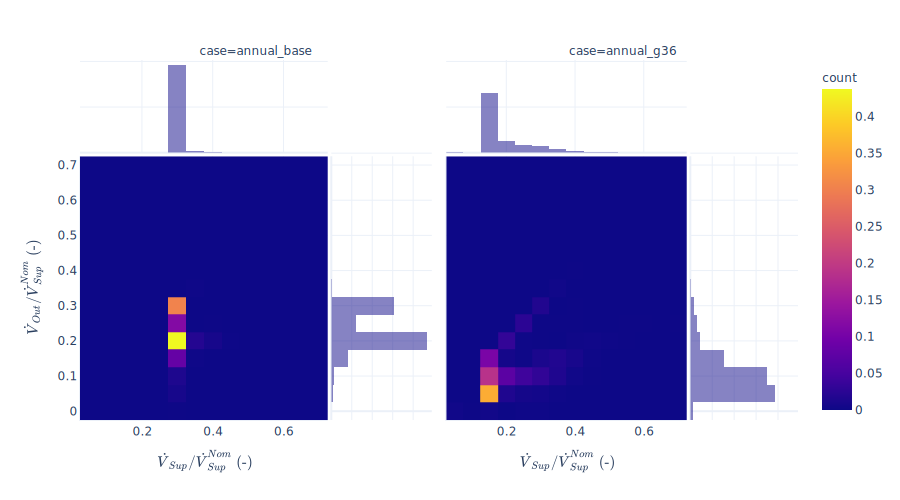

In [97]:
img = fig.to_image(format='svg')
display(SVG(img))

In [98]:
fig.write_image('plt.png')

In [40]:
toplot.groupby('case')['ratSupFlo'].describe()

,count,mean,std,min,25%,50%,75%,max
case,,,,,,,,
annual_base,298520.0,0.300360,0.008683,0.073997,0.298395,0.298416,0.298423,0.431095
annual_g36,365538.0,0.233789,0.097068,0.012414,0.149571,0.192144,0.311796,0.672375


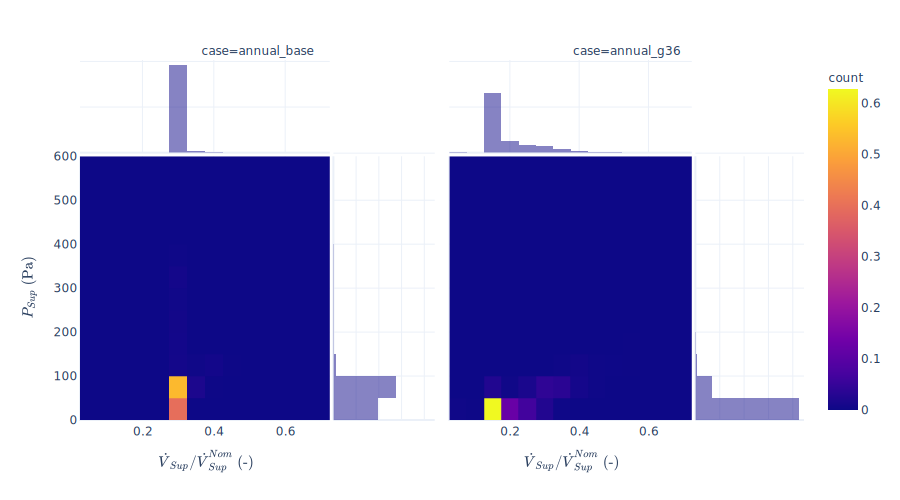

In [68]:
tmp = toplot
nbins = 20 
x = 'ratSupFlo'
y = 'dpDisSupFan.p_rel'

fig = px.density_heatmap(
    tmp,
    facet_col='case',
    x='ratSupFlo', y='dpDisSupFan.p_rel',
    labels={
        x: r'$\dot{V}_{Sup}/\dot{V}_{Sup}^{Nom} \text{ (-)}$', 
        y: r'$P_{Sup} \text{ (Pa)}$',
    },
    nbinsx=nbins, nbinsy=nbins, 
    histnorm='probability', 
    marginal_x='histogram', 
)
# Update figure to add marginal_y, disabled in case of facet_col.
fig = fig.update_layout(
    width=900,
    xaxis=dict(domain=[0, 0.345]),
    xaxis3=dict(domain=[0.35, 0.49], showticklabels=False, matches='x3'),
    xaxis2=dict(domain=[0.51, 0.845]),
    xaxis4=dict(domain=[0.85, 1], showticklabels=False, matches='x3'),
)
fig = fig.update_traces(xaxis='x', selector=dict(xaxis='x3'))
fig = fig.update_traces(xaxis='x2', selector=dict(xaxis='x4'))
fig = fig.update_traces(histnorm='probability', selector=dict(yaxis='y3'))
fig = fig.update_traces(histnorm='probability', selector=dict(yaxis='y4'))
toadd = px.histogram(tmp, y=y, facet_col='case', histnorm='probability', nbins=nbins).data
fig = fig.add_trace(toadd[0], row=1, col=2)
fig.data[-1].xaxis = 'x3'; fig.data[-1].marker = {'color': '#0d0887'}; fig.data[-1].opacity = 0.5
fig = fig.add_trace(toadd[1], row=1, col=2)
fig.data[-1].xaxis = 'x4'; fig.data[-1].marker = {'color': '#0d0887'}; fig.data[-1].opacity = 0.5

img = fig.to_image(format='svg')
display(SVG(img))

In [233]:
toplot.groupby('case')['dpDisSupFan.p_rel'].describe()

,count,mean,std,min,25%,50%,75%,max
case,,,,,,,,
annual_base,298520.0,59.908264,39.255523,4.440717,49.999977,50.000004,50.000191,590.793030
annual_g36,365538.0,53.937214,42.899942,0.668037,24.999495,27.505989,75.377083,364.120575
